It shows how to use the Tensorflow do the construction of a VAE model.

In [0]:
import os
import scipy.misc
import numpy as np
import tensorflow as tf
import time
import math
import matplotlib.pyplot as plt


# Util function

def binary_cross_entropy(preds, targets, name=None):
    # The custimized binary cross entropy loss function
    # Basically is the negative log-likelihood
    eps = 1e-12
    with tf.op_scope([preds, targets], name, "bce_loss") as name:
        preds = tf.convert_to_tensor(preds, name="preds")
        targets = tf.convert_to_tensor(targets, name="targets")
        return tf.reduce_mean(-(targets * tf.log(preds + eps) +
                              (1. - targets) * tf.log(1. - preds + eps)))

def conv2d(input_, output_dim, k_h=5, k_w=5, d_h=2, d_w=2, stddev=0.02, name="conv2d"):
    # The function is used to construct one simple Conv layer in tensorflow
    # Remeber to specify one unique name for one layer
    with tf.variable_scope(name):
        w = tf.get_variable('w', [k_h, k_w, input_.get_shape()[-1], output_dim],
                            initializer=tf.truncated_normal_initializer(stddev=stddev))
        conv = tf.nn.conv2d(input_, w, strides=[1, d_h, d_w, 1], padding='SAME')
        biases = tf.get_variable('biases', [output_dim], initializer=tf.constant_initializer(0.0))
        conv = tf.reshape(tf.nn.bias_add(conv, biases), conv.get_shape())
        return conv

def deconv2d(input_, output_shape, k_h=5, k_w=5, d_h=2, d_w=2, stddev=0.02, name="deconv2d"):
    # The function is used to construct one simple Deconv layer in tensorflow
    # Remeber to specify one unique name for one layer 
    with tf.variable_scope(name):
        # filter : [height, width, output_channels, in_channels]
        w = tf.get_variable('w', [k_h, k_w, output_shape[-1], input_.get_shape()[-1]],
                            initializer=tf.random_normal_initializer(stddev=stddev))
        deconv = tf.nn.conv2d_transpose(input_, w, output_shape=output_shape,
                                        strides=[1, d_h, d_w, 1])
        biases = tf.get_variable('biases', [output_shape[-1]], initializer=tf.constant_initializer(0.0))
        deconv = tf.reshape(tf.nn.bias_add(deconv, biases), deconv.get_shape())
        return deconv

def batch_norm(input, epsilon=1e-5, momentum=0.9, train=True, name="batch_norm"):
    # The function is used to construct one simple Batch Norm layer in tensorflow
    # Remeber to specify one unique name for one layer
    return tf.contrib.layers.batch_norm(input, decay=momentum, updates_collections=None,
            epsilon=epsilon, scale=True, is_training=train, scope=name)

def lrelu(x, leak=0.2, name="lrelu"):
    # The function is used to construct one simple Leaky Relu layer in tensorflow
    # Remeber to specify one unique name for one layer
    return tf.maximum(x, leak*x)

def linear(input_, output_size, scope=None, stddev=0.02, bias_start=0.0, with_w=False):
    # The function is used to construct one simple Fully Connected layer in tensorflow
    # Remeber to specify one unique name for one layer
    shape = input_.get_shape().as_list()
    with tf.variable_scope(scope or "Linear"):
        matrix = tf.get_variable("Matrix", [shape[1], output_size], tf.float32,
                                 tf.random_normal_initializer(stddev=stddev))
        bias = tf.get_variable("bias", [output_size],
            initializer=tf.constant_initializer(bias_start))
        if with_w:
            return tf.matmul(input_, matrix) + bias, matrix, bias
        else:
            return tf.matmul(input_, matrix) + bias

def img2cell(images, col_num=25, margin=2):
    # It used to stick the digit images into one big image
    [num_images, size_h, size_w, n_channel] = images.shape
    row_num = int(math.ceil(num_images/col_num))
    saved_img = np.zeros(((row_num * size_h + margin * (row_num - 1)),
                          (col_num * size_w + margin * (col_num - 1)),
                          n_channel), dtype=np.float32)
    for idx in range(num_images):
        ir = int(math.floor(idx / col_num))
        ic = idx % col_num
        saved_img[(size_h + margin) * ir:size_h + (size_h + margin) * ir,
        (size_w + margin) * ic:size_w + (size_w + margin) * ic, :] = images[idx]
    return saved_img.squeeze()

In [0]:
class VAE(object):
    def __init__(self, sess, image_size=28, batch_size=100, sample_size=100, z_dim=5, c_dim=1, device_name="cpu"):
        """
        Args:
            sess: TensorFlow session
            image_size: The size of input image.
            batch_size: The size of batch. Should be specified before training.
            sample_size: (optional) The size of sampling. Should be specified before training.
            output_size: (optional) The resolution in pixels of the images. [28]
            z_dim: (optional) Dimension of latent vectors. [5]
            c_dim: (optional) Dimension of image color. For grayscale input, set to 1. [1]
        """
        self.sess = sess
        self.batch_size = batch_size
        self.input_size = image_size
        self.sample_size = sample_size
        self.output_size = image_size
        self.print_step = 1

        self.z_dim = z_dim
        self.c_dim = 1

        self.dataset_name = 'mnist'
        self.device_name = device_name
        
        # Choose to use GPU or CPU
        if self.device_name == "gpu":
            self.device_name = "/gpu:0"
        else:
            self.device_name = "/cpu:0"
        
        with tf.device(device_name):
            self.build_model()
        
        # To save the model
        self.saver = tf.train.Saver()
        
    def encoder(self, image, z_dim, reuse=False, train=True):
        with tf.variable_scope("encoder", reuse=reuse):
            
            # Construct Encoder layers
            h1 = conv2d(image,32,k_h=3,k_w=3,name='Conv1')
            h1 = batch_norm(h1,name='bn1',train=train)
            h1 = lrelu(h1,leak=0.1,name='relu1')
            h2 = conv2d(h1,64,k_h=3,k_w=3,name='Conv2')
            h2 = batch_norm(h2,name='bn2',train=train)
            h2 = lrelu(h2,leak=0.1,name='relu2')
            h2 = tf.reshape(h2,[self.batch_size,-1])
            
            # The learnt mean and std for the normal distribution
            mean = linear(h2,self.z_dim,scope='Mean')
            std = linear(h2,self.z_dim,scope='log_Sd')

            return mean, std

    def decoder(self, z, reuse=False, train=True):
        with tf.variable_scope("decoder", reuse=reuse):
            
            # Construct the Decoder layers
            h3 = linear(z,49*64,scope='dense3')
            h3 = lrelu(h3,leak=0.1,name='relu3')
            h3 = tf.reshape(h3,[self.batch_size,7,7,64])
            h4 = deconv2d(h3,[self.batch_size,14,14,32],k_h=3,k_w=3,name='deconv4')
            h4 = batch_norm(h4,name='bn4',train=train)
            h4 = lrelu(h4,leak=0.1,name='relu4')
            h5 = deconv2d(h4,[self.batch_size,self.input_size,self.input_size,self.c_dim],k_h=3,k_w=3,name='deconv5')
            h5 = batch_norm(h5,name='bn5',train=train)
            
            return tf.nn.sigmoid(h5)

    def build_model(self):
        
        # variables : input
        self.x = tf.placeholder(tf.float32, shape=(self.batch_size, self.input_size, self.input_size, self.c_dim))
        self.isTrain = tf.placeholder(dtype=tf.bool)

        # networks :
        
        self.z_mean, self.z_std = self.encoder(self.x,self.z_dim,train=self.isTrain)
        
        z_sample = tf.random.normal([self.batch_size,self.z_dim])
        
        self.z = tf.add(self.z_mean,tf.exp(self.z_std)*z_sample)
        
        self.recon = self.decoder(self.z,train=self.isTrain)
        
        self.loglik = tf.reduce_mean(binary_cross_entropy(self.x,self.recon),keep_dims=False)
        
        self.divergence = -0.5*tf.reduce_mean(1.+self.z_std-tf.square(self.z_mean)-tf.exp(self.z_std),keep_dims=False)
        
        self.loss = self.loglik+self.divergence
        
    def train(self, num_epoch=25, lr=0.0002, beta1=0.5, is_crop=False, visualize=True):
        """Train VAE"""
        # load MNIST dataset
        mnist = tf.keras.datasets.mnist
        (data, _), (_,_) = mnist.load_data()
        data = np.reshape(data, [-1, 28, 28, 1]).astype(np.float32) / 255
        data_len = data.shape[0]
        optim = tf.train.AdamOptimizer(lr, beta1=beta1).minimize(self.loss)
        try:
            self.sess.run(tf.global_variables_initializer())
        except:
            tf.initialize_all_variables().run()
        t_vars = tf.trainable_variables()

        # Record the start time
        start_time = time.time()
        counter = 1
        train_hist = {}
        train_hist['losses_L'] = []
        train_hist['losses_KL'] = []
        
        # Sample the values from a standard normal distribution to
        # reconstruct the images
        z_sample = np.random.normal(0, 1, size=[self.sample_size, self.z_dim])
        output_image = img2cell(data[0:100, ...])
        
        # Show a sample of the training data
        print("Original Image: ")
        plt.imshow(output_image)
        plt.axis('off')
        plt.show()
            
        # The training process
        for epoch in range(num_epoch):
            
            # Set up the batch index and the starting loss
            batch_idxs = data_len // self.batch_size
            batch_total_loss = batch_loss_likelihood = batch_loss_divergence = 0

            epoch_start_time = time.time()
            
            for idx in range(0, batch_idxs):
                counter += 1
                
                # One batch of images
                batch_images = data[idx*self.batch_size:(idx+1)*self.batch_size, :]
                
                # Train this one batch of data
                self.sess.run(optim,feed_dict={self.x:batch_images,self.isTrain: True})
                
                # Calculate the each part of the loss
                training_loglik = self.sess.run(self.loglik,feed_dict={self.x:batch_images,self.isTrain: True})
                training_divergence = self.sess.run(self.divergence,feed_dict={self.x:batch_images,self.isTrain: True})
                training_loss = self.sess.run(self.loss,feed_dict={self.x:batch_images,self.isTrain: True})
        
                batch_loss_likelihood += training_loglik
                batch_loss_divergence += training_divergence
                batch_total_loss += training_loss
            
            # Plot out the reconstructed images and the sampling images
            if epoch % self.print_step == 0:
                sample_image = self.sess.run(self.recon, {self.z: z_sample,self.isTrain: True})
                output_image = img2cell(sample_image)
                print("Epoch %d : Sampling Image: " % epoch)
                plt.imshow(output_image)
                plt.axis('off')
                plt.show()
                recons_image = self.sess.run(self.recon, {self.x: data[0:100, ...],self.isTrain: False})
                output_image = img2cell(recons_image)
                print("Epoch %d : Reconstruct Image: " % epoch)
                plt.imshow(output_image)
                plt.axis('off')
                plt.show()

            epoch_end_time = time.time()
            batch_total_loss /= batch_idxs
            batch_loss_likelihood /= batch_idxs
            batch_loss_divergence /= batch_idxs
            per_epoch_ptime = epoch_end_time - epoch_start_time
            print('[%d/%d] - ptime: %.2f Total_loss=(L+KL): %.3f = (%.3f+%.3f)' 
                  % ((epoch + 1), num_epoch, per_epoch_ptime, batch_total_loss, batch_loss_likelihood, batch_loss_divergence))
            train_hist['losses_L'].append(batch_loss_likelihood)
            train_hist['losses_KL'].append(batch_loss_divergence)
        plt.plot(train_hist['losses_L'])
        plt.plot(train_hist['losses_KL'])
        plt.show()

Instructions for updating:
Colocations handled automatically by placer.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

11493376/11490434 [==============================] - 0s 0us/step
Original Image: 


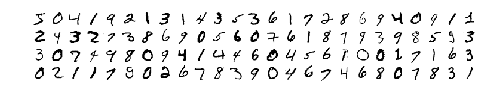

Epoch 0 : Sampling Image: 


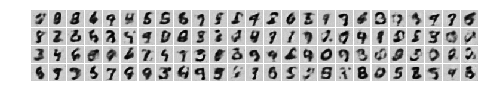

Epoch 0 : Reconstruct Image: 


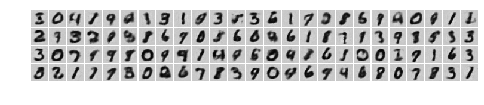

[1/25] - ptime: 14.89 Total_loss=(L+KL): 9.155 = (8.918+0.237)
Epoch 1 : Sampling Image: 


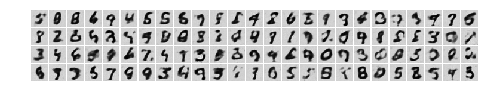

Epoch 1 : Reconstruct Image: 


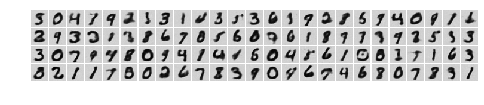

[2/25] - ptime: 10.99 Total_loss=(L+KL): 8.109 = (7.852+0.257)
Epoch 2 : Sampling Image: 


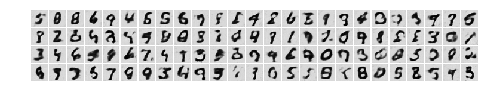

Epoch 2 : Reconstruct Image: 


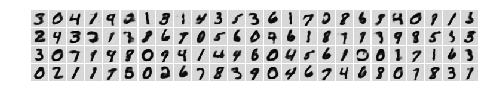

[3/25] - ptime: 11.12 Total_loss=(L+KL): 7.312 = (7.037+0.275)
Epoch 3 : Sampling Image: 


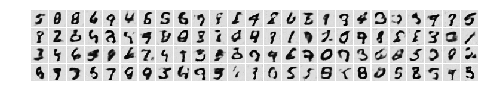

Epoch 3 : Reconstruct Image: 


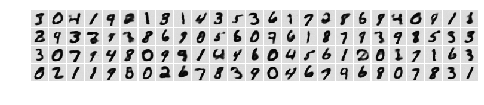

[4/25] - ptime: 11.00 Total_loss=(L+KL): 6.600 = (6.309+0.290)
Epoch 4 : Sampling Image: 


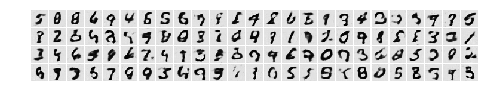

Epoch 4 : Reconstruct Image: 


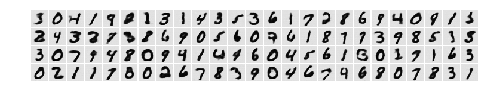

[5/25] - ptime: 11.10 Total_loss=(L+KL): 5.958 = (5.654+0.304)
Epoch 5 : Sampling Image: 


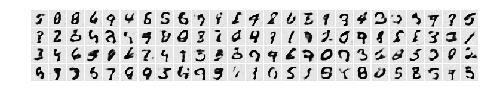

Epoch 5 : Reconstruct Image: 


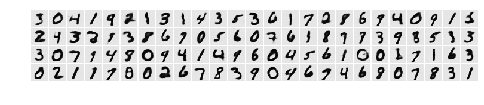

[6/25] - ptime: 11.11 Total_loss=(L+KL): 5.381 = (5.069+0.314)
Epoch 6 : Sampling Image: 


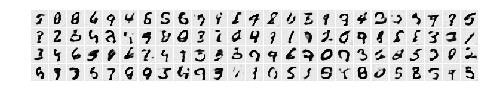

Epoch 6 : Reconstruct Image: 


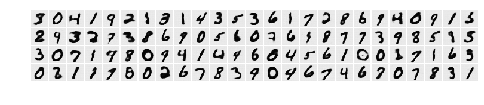

[7/25] - ptime: 10.98 Total_loss=(L+KL): 4.864 = (4.543+0.322)
Epoch 7 : Sampling Image: 


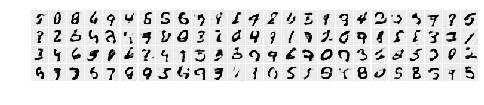

Epoch 7 : Reconstruct Image: 


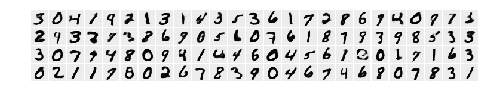

[8/25] - ptime: 10.95 Total_loss=(L+KL): 4.400 = (4.071+0.329)
Epoch 8 : Sampling Image: 


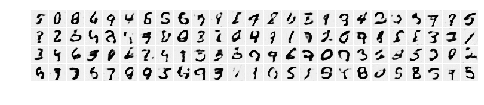

Epoch 8 : Reconstruct Image: 


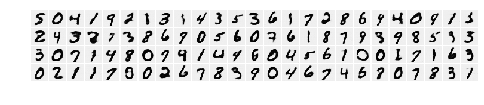

[9/25] - ptime: 10.89 Total_loss=(L+KL): 3.985 = (3.651+0.334)
Epoch 9 : Sampling Image: 


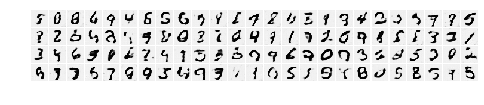

Epoch 9 : Reconstruct Image: 


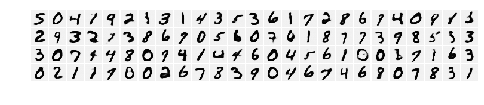

[10/25] - ptime: 11.02 Total_loss=(L+KL): 3.613 = (3.276+0.338)
Epoch 10 : Sampling Image: 


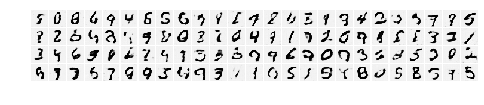

Epoch 10 : Reconstruct Image: 


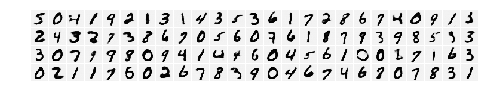

[11/25] - ptime: 11.10 Total_loss=(L+KL): 3.281 = (2.940+0.341)
Epoch 11 : Sampling Image: 


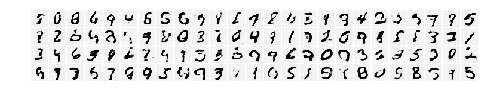

Epoch 11 : Reconstruct Image: 


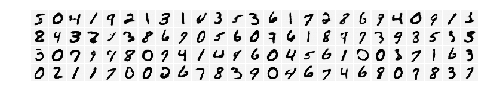

[12/25] - ptime: 10.95 Total_loss=(L+KL): 2.985 = (2.643+0.341)
Epoch 12 : Sampling Image: 


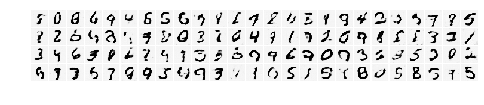

Epoch 12 : Reconstruct Image: 


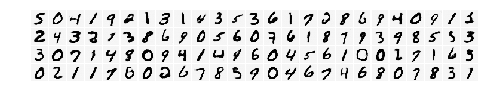

[13/25] - ptime: 11.02 Total_loss=(L+KL): 2.721 = (2.378+0.343)
Epoch 13 : Sampling Image: 


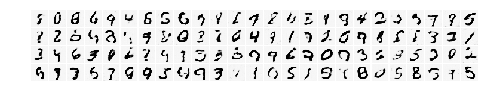

Epoch 13 : Reconstruct Image: 


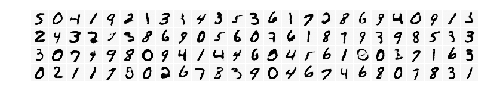

[14/25] - ptime: 11.01 Total_loss=(L+KL): 2.484 = (2.141+0.343)
Epoch 14 : Sampling Image: 


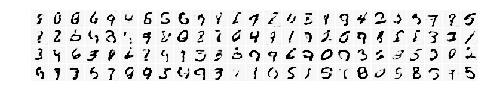

Epoch 14 : Reconstruct Image: 


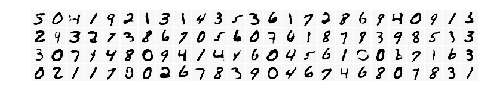

[15/25] - ptime: 10.97 Total_loss=(L+KL): 2.275 = (1.931+0.342)
Epoch 15 : Sampling Image: 


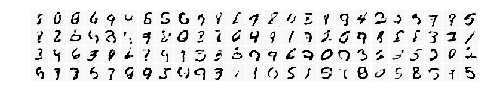

Epoch 15 : Reconstruct Image: 


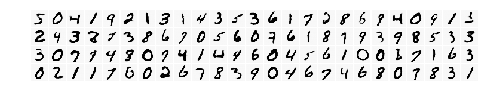

[16/25] - ptime: 11.17 Total_loss=(L+KL): 2.086 = (1.746+0.341)
Epoch 16 : Sampling Image: 


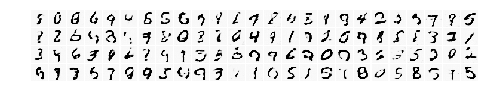

Epoch 16 : Reconstruct Image: 


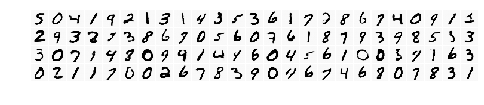

[17/25] - ptime: 10.99 Total_loss=(L+KL): 1.919 = (1.579+0.340)
Epoch 17 : Sampling Image: 


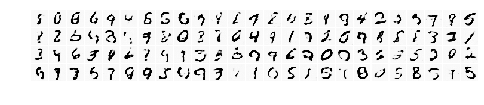

Epoch 17 : Reconstruct Image: 


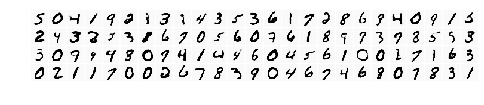

[18/25] - ptime: 11.00 Total_loss=(L+KL): 1.771 = (1.432+0.338)
Epoch 18 : Sampling Image: 


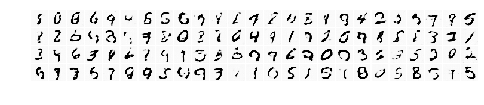

Epoch 18 : Reconstruct Image: 


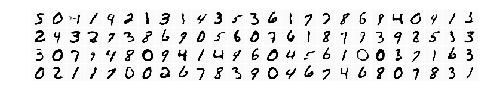

[19/25] - ptime: 10.95 Total_loss=(L+KL): 1.637 = (1.302+0.336)
Epoch 19 : Sampling Image: 


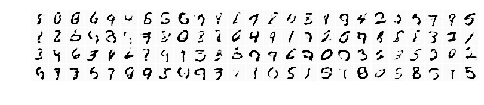

Epoch 19 : Reconstruct Image: 


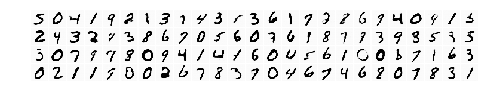

[20/25] - ptime: 10.97 Total_loss=(L+KL): 1.519 = (1.184+0.334)
Epoch 20 : Sampling Image: 


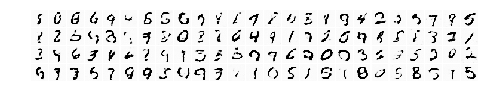

Epoch 20 : Reconstruct Image: 


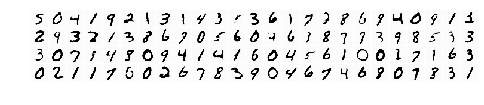

[21/25] - ptime: 10.93 Total_loss=(L+KL): 1.414 = (1.083+0.331)
Epoch 21 : Sampling Image: 


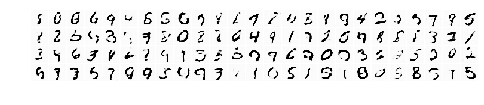

Epoch 21 : Reconstruct Image: 


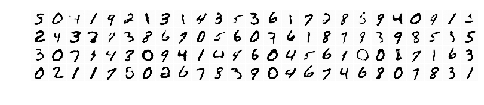

[22/25] - ptime: 11.02 Total_loss=(L+KL): 1.319 = (0.992+0.328)
Epoch 22 : Sampling Image: 


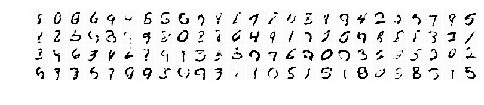

Epoch 22 : Reconstruct Image: 


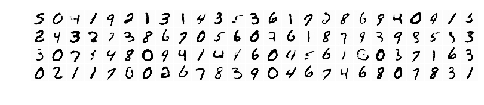

[23/25] - ptime: 11.01 Total_loss=(L+KL): 1.236 = (0.910+0.326)
Epoch 23 : Sampling Image: 


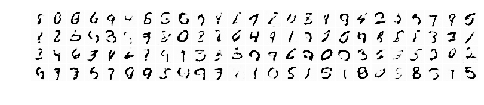

Epoch 23 : Reconstruct Image: 


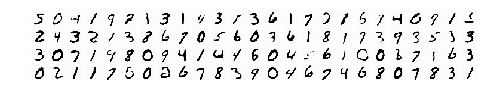

[24/25] - ptime: 10.94 Total_loss=(L+KL): 1.161 = (0.838+0.323)
Epoch 24 : Sampling Image: 


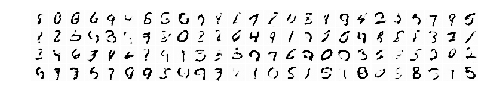

Epoch 24 : Reconstruct Image: 


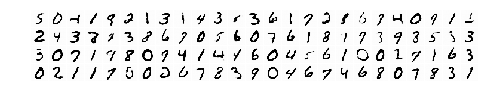

[25/25] - ptime: 11.16 Total_loss=(L+KL): 1.094 = (0.776+0.320)


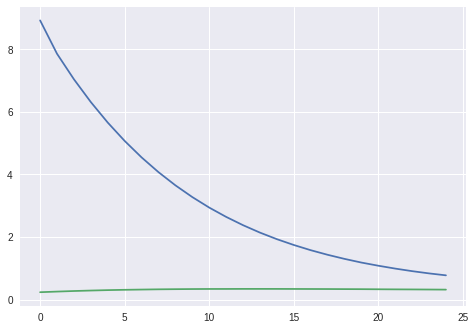

In [3]:
with tf.Session() as sess:
    vae = VAE(sess,image_size=28,z_dim=20,device_name="gpu")
    vae.train(num_epoch=25, lr=0.0002, beta1=0.5)